In [95]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
import folium
from statsmodels.tsa.arima.model import ARIMA

In [55]:
!pip install folium

In [48]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')


In [49]:
#Read in data
df = pd.read_csv('Amazon Sales data.csv') 

In [50]:
df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,5/28/2010,669165933,6/27/2010,9925,255.28,159.42,2533654.00,1582243.50,951410.50
1,Central America and the Caribbean,Grenada,Cereal,Online,C,8/22/2012,963881480,9/15/2012,2804,205.70,117.11,576782.80,328376.44,248406.36
2,Europe,Russia,Office Supplies,Offline,L,5/2/2014,341417157,5/8/2014,1779,651.21,524.96,1158502.59,933903.84,224598.75
3,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Online,C,6/20/2014,514321792,7/5/2014,8102,9.33,6.92,75591.66,56065.84,19525.82
4,Sub-Saharan Africa,Rwanda,Office Supplies,Offline,L,2/1/2013,115456712,2/6/2013,5062,651.21,524.96,3296425.02,2657347.52,639077.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Sub-Saharan Africa,Mali,Clothes,Online,M,7/26/2011,512878119,9/3/2011,888,109.28,35.84,97040.64,31825.92,65214.72
96,Asia,Malaysia,Fruits,Offline,L,11/11/2011,810711038,12/28/2011,6267,9.33,6.92,58471.11,43367.64,15103.47
97,Sub-Saharan Africa,Sierra Leone,Vegetables,Offline,C,6/1/2016,728815257,6/29/2016,1485,154.06,90.93,228779.10,135031.05,93748.05
98,North America,Mexico,Personal Care,Offline,M,7/30/2015,559427106,8/8/2015,5767,81.73,56.67,471336.91,326815.89,144521.02


# Data cleaning

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.dropna(inplace=True)

In [20]:
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [21]:
# Fill missing values for Country with Unknown
df['Country'].fillna('Unknown', inplace=True)

In [22]:
# Remove rows with missing Sales Channel 
df.dropna(subset=['Sales Channel'], inplace=True)

In [23]:
# Remove rows with erroneous data
df = df[df['Unit Price'] > 0]
df = df[df['Units Sold'] > 0]

In [24]:
# Remove outliers using IQR 
Q1 = df['Total Revenue'].quantile(0.25)
Q3 = df['Total Revenue'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['Total Revenue'] > lower) & (df['Total Revenue'] < upper)]

In [25]:
# Normalize revenue  
max_rev = df['Total Revenue'].max()
df['Normalized Revenue'] = df['Total Revenue']/max_rev

In [30]:
# Export cleaned data
df.to_csv('amazon_cleaned.csv', index=False)

In [5]:
#Monthly trends
df['Month'] = df['Order Date'].dt.month
monthly_sales = df.groupby('Month')['Total Revenue'].sum().reset_index()


In [8]:
# Yearly trends  
df['Year'] = df['Order Date'].dt.year
yearly_sales = df.groupby('Year')['Total Revenue'].sum().reset_index()


In [9]:
df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,Month,Year
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,2010-05-28,669165933,6/27/2010,9925,255.28,159.42,2533654.00,1582243.50,951410.50,5,2010
1,Central America and the Caribbean,Grenada,Cereal,Online,C,2012-08-22,963881480,9/15/2012,2804,205.70,117.11,576782.80,328376.44,248406.36,8,2012
2,Europe,Russia,Office Supplies,Offline,L,2014-05-02,341417157,5/8/2014,1779,651.21,524.96,1158502.59,933903.84,224598.75,5,2014
3,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Online,C,2014-06-20,514321792,7/5/2014,8102,9.33,6.92,75591.66,56065.84,19525.82,6,2014
4,Sub-Saharan Africa,Rwanda,Office Supplies,Offline,L,2013-02-01,115456712,2/6/2013,5062,651.21,524.96,3296425.02,2657347.52,639077.50,2,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Sub-Saharan Africa,Mali,Clothes,Online,M,2011-07-26,512878119,9/3/2011,888,109.28,35.84,97040.64,31825.92,65214.72,7,2011
96,Asia,Malaysia,Fruits,Offline,L,2011-11-11,810711038,12/28/2011,6267,9.33,6.92,58471.11,43367.64,15103.47,11,2011
97,Sub-Saharan Africa,Sierra Leone,Vegetables,Offline,C,2016-06-01,728815257,6/29/2016,1485,154.06,90.93,228779.10,135031.05,93748.05,6,2016
98,North America,Mexico,Personal Care,Offline,M,2015-07-30,559427106,8/8/2015,5767,81.73,56.67,471336.91,326815.89,144521.02,7,2015


In [10]:
# Yearly month trends
df['Year-Month'] = df['Order Date'].apply(lambda x: x.strftime('%Y-%m'))
ym_sales = df.groupby('Year-Month')['Total Revenue'].sum().reset_index() 

In [11]:
df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,Month,Year,Year-Month
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,2010-05-28,669165933,6/27/2010,9925,255.28,159.42,2533654.00,1582243.50,951410.50,5,2010,2010-05
1,Central America and the Caribbean,Grenada,Cereal,Online,C,2012-08-22,963881480,9/15/2012,2804,205.70,117.11,576782.80,328376.44,248406.36,8,2012,2012-08
2,Europe,Russia,Office Supplies,Offline,L,2014-05-02,341417157,5/8/2014,1779,651.21,524.96,1158502.59,933903.84,224598.75,5,2014,2014-05
3,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Online,C,2014-06-20,514321792,7/5/2014,8102,9.33,6.92,75591.66,56065.84,19525.82,6,2014,2014-06
4,Sub-Saharan Africa,Rwanda,Office Supplies,Offline,L,2013-02-01,115456712,2/6/2013,5062,651.21,524.96,3296425.02,2657347.52,639077.50,2,2013,2013-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Sub-Saharan Africa,Mali,Clothes,Online,M,2011-07-26,512878119,9/3/2011,888,109.28,35.84,97040.64,31825.92,65214.72,7,2011,2011-07
96,Asia,Malaysia,Fruits,Offline,L,2011-11-11,810711038,12/28/2011,6267,9.33,6.92,58471.11,43367.64,15103.47,11,2011,2011-11
97,Sub-Saharan Africa,Sierra Leone,Vegetables,Offline,C,2016-06-01,728815257,6/29/2016,1485,154.06,90.93,228779.10,135031.05,93748.05,6,2016,2016-06
98,North America,Mexico,Personal Care,Offline,M,2015-07-30,559427106,8/8/2015,5767,81.73,56.67,471336.91,326815.89,144521.02,7,2015,2015-07


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 [Text(0, 0, '2010-02'),
  Text(1, 0, '2010-05'),
  Text(2, 0, '2010-06'),
  Text(3, 0, '2010-10'),
  Text(4, 0, '2010-11'),
  Text(5, 0, '2010-12'),
  Text(6, 0, '2011-01'),
  Text(7, 0, '2011-02'),
  Text(8, 0, '2011-04'),
  Text(9, 0, '2011-05'),
  Text(10, 0, '2011-06'),
  Text(11, 0, '2011-07'),
  Text(12, 0, '2011-09'),
  Text(13, 0, '2011-11'),
  Text(14, 0, '2012-01'),
  Text(15, 0, '2012-02'),
  Text(16, 0, '2012-03'),
  Text(17, 0, '2012-04'),
  Text(18, 0, '2012-05'),
  Text(19, 0, '2012-06'),
  Text(20, 0, '2012-07'),
  Text(21, 0, '2012-08'),
  Text(22, 0, '2012-09'),
  Text(23, 0, '2012-10'),
  Text(24, 0, '2013-02'),
  Text(25, 0, '2013-03'),
  Text(26, 0, '2013-04'),
  Text(27, 0, '2013-06'),
  Text(2

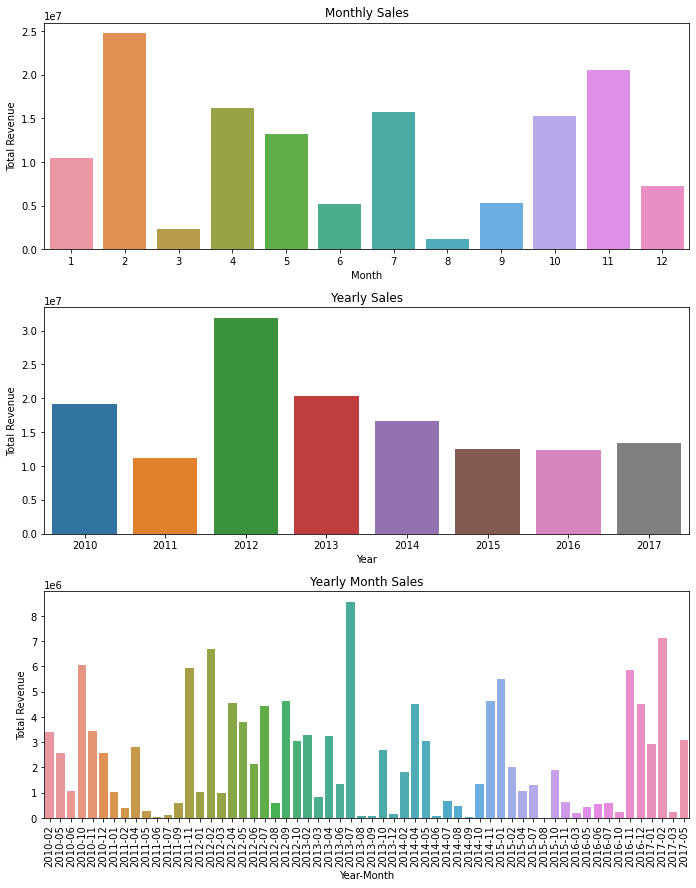

In [31]:
# Plot trends
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

sns.barplot(x='Month', y='Total Revenue', data=monthly_sales, ax=axs[0])
axs[0].set_title('Monthly Sales')

sns.barplot(x='Year', y='Total Revenue', data=yearly_sales, ax=axs[1])
axs[1].set_title('Yearly Sales')

sns.barplot(x='Year-Month', y='Total Revenue', data=ym_sales, ax=axs[2])
axs[2].set_title('Yearly Month Sales')

plt.tight_layout()
plt.xticks(rotation='vertical')

In [141]:
df.dtypes

Region              object
Country             object
Item Type           object
Sales Channel       object
Order Priority    category
Order Date          object
Order ID             int64
Ship Date           object
Units Sold           int64
Unit Price         float64
Unit Cost          float64
Total Revenue      float64
Total Cost         float64
Total Profit       float64
dtype: object

# Data analysis

<AxesSubplot:xlabel='Order Date', ylabel='Total Revenue'>

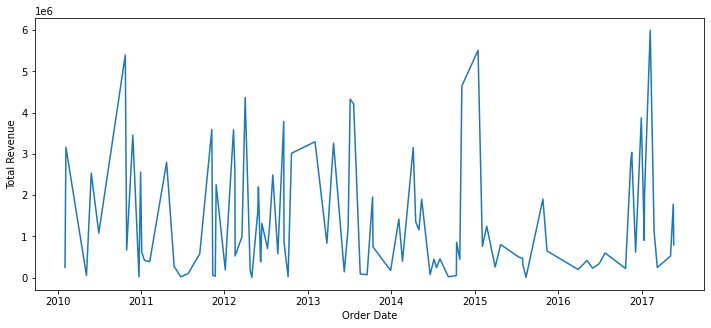

In [19]:
# Sales over time 
sales_ts = df.groupby('Order Date')['Total Revenue'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(x='Order Date', y='Total Revenue', data=sales_ts)

<AxesSubplot:xlabel='Region', ylabel='Total Revenue'>

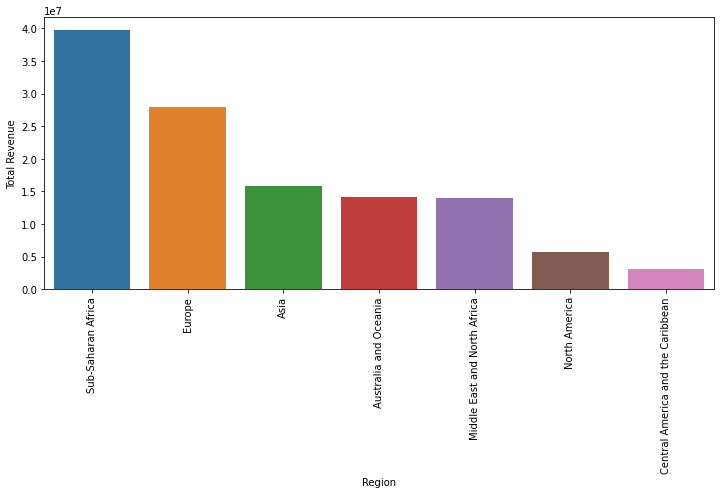

In [32]:
# Sales by region
sales_region = df.groupby('Region')['Total Revenue'].sum().reset_index()
sales_region = sales_region.sort_values('Total Revenue', ascending=False)
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.barplot(x='Region', y='Total Revenue', data=sales_region[:10])

<AxesSubplot:xlabel='Item Type', ylabel='Total Revenue'>

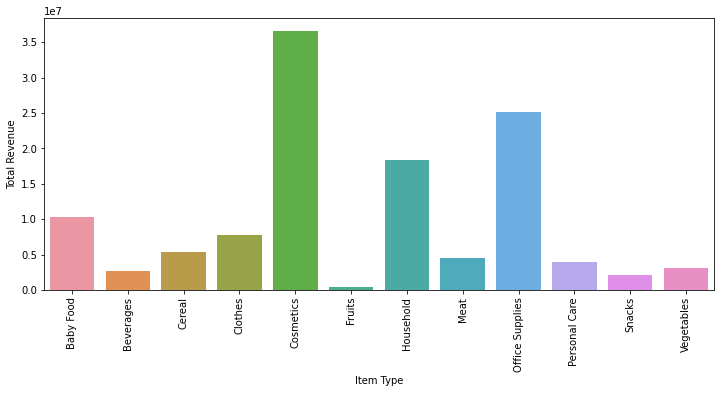

In [33]:
# Sales by product category
prod_sales = df.groupby('Item Type')['Total Revenue'].sum().reset_index()
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.barplot(x='Item Type', y='Total Revenue', data=prod_sales)

In [28]:
# Sales channels performance 
channel_sales = df.groupby('Sales Channel')['Total Revenue'].sum().reset_index()

In [29]:
# Profitability by product
prod_profit = df.groupby('Item Type')['Total Profit'].sum().reset_index()

In [34]:
# Key Metrics
total_revenue = df['Total Revenue'].sum() 
total_profit = df['Total Profit'].sum()

print('Total Revenue:', total_revenue)
print('Total Profit:', total_profit)

Total Revenue: 120441908.56
Total Profit: 40267431.129999995


In [35]:
# Groupby for segmentation
by_product = df.groupby('Item Type').agg({'Total Revenue': 'sum', 'Total Profit':'sum'})
by_region = df.groupby('Region').agg({'Total Revenue': 'sum', 'Total Profit':'sum'})

print(by_product)
print(by_region)

                 Total Revenue  Total Profit
Item Type                                   
Baby Food          10350327.60    3886643.70
Beverages           2690794.60     888047.28
Cereal              5322898.90    2292443.43
Clothes             7787292.80    5233334.40
Cosmetics          36601509.60   14556048.66
Fruits               466481.34     120495.18
Household          18379429.81    4558072.19
Meat                4503675.75     610610.00
Office Supplies    25188802.80    4883350.00
Personal Care       3980904.84    1220622.48
Snacks              2080733.46     751944.18
Vegetables          3089057.06    1265819.63
                                   Total Revenue  Total Profit
Region                                                        
Asia                                 15833863.52    4746573.37
Australia and Oceania                14094265.13    4722160.03
Central America and the Caribbean     3173330.51    1359646.83
Europe                               27972354.84   1003

In [37]:
# Relationships
corr = df.corr()
print(corr['Total Revenue'].sort_values(ascending=False)) 

Normalized Revenue    1.000000
Total Revenue         1.000000
Total Cost            0.979249
Total Profit          0.895364
Unit Price            0.735783
Unit Cost             0.687237
Units Sold            0.403070
Month                 0.071973
Year                 -0.093130
Order ID             -0.268904
Name: Total Revenue, dtype: float64


In [38]:
# Statistical Modeling
X = df[['Unit Price', 'Units Sold']] 
y = df['Total Revenue']

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)

print(lm.coef_)
print(lm.intercept_)

[4484.15348558  237.009416  ]
-1136676.6921240403


In [44]:
# Forecasting 
model = ARIMA(df['Total Revenue'], order=(1,1,1))  
model_fit = model.fit()
print(model_fit.forecast(steps=5))

97     1.393529e+06
98     1.248692e+06
99     1.239126e+06
100    1.238495e+06
101    1.238453e+06
Name: predicted_mean, dtype: float64


# Visualizations

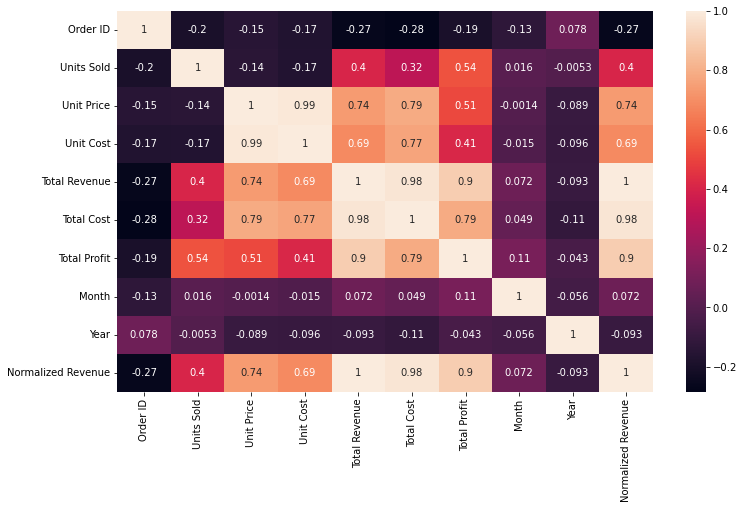

In [71]:
plt.figure(figsize=(12,7))
sns.heatmap(corr, annot=True)
plt.savefig('correlation.png')

folium_map = folium.Map()
for tc, tp, value in zip(df['Total Cost'], df['Total Profit'], df['Total Revenue']):
    folium.CircleMarker([tc, tp], radius=value/500000, popup=value).add_to(folium_map)

folium_map.save('sales_map.html')

From the above heatmap, we can infer that Total Cost is strongly related to Unit Price,Unit Cost and Total Profit. 
Units Sold and {Unit Price and Unit Cost} are completely independent. Number of units sold are independent of price charged per unit of a product and same with cost of a unit which is independent of units sold. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Baby Food'),
  Text(1, 0, 'Cereal'),
  Text(2, 0, 'Office Supplies'),
  Text(3, 0, 'Fruits'),
  Text(4, 0, 'Household'),
  Text(5, 0, 'Vegetables'),
  Text(6, 0, 'Personal Care'),
  Text(7, 0, 'Clothes'),
  Text(8, 0, 'Cosmetics'),
  Text(9, 0, 'Beverages'),
  Text(10, 0, 'Meat'),
  Text(11, 0, 'Snacks')])

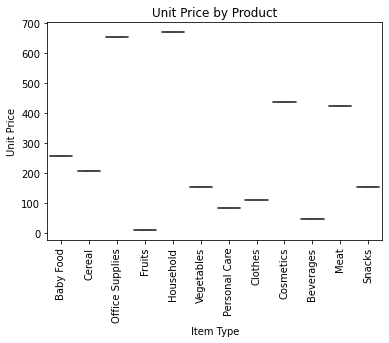

In [74]:
# Boxplot for unit price by product category
sns.boxplot(x='Item Type', y='Unit Price', data=df)
plt.title('Unit Price by Product')
plt.xticks(rotation='vertical')

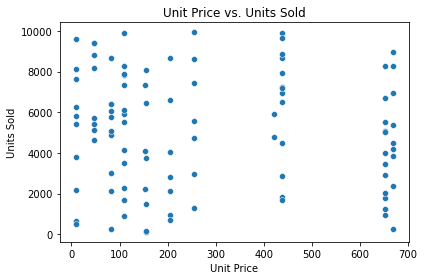

In [73]:
# Scatterplot price vs. units sold
sns.scatterplot(x='Unit Price', y='Units Sold', data=df)
plt.title('Unit Price vs. Units Sold')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Total Revenue')

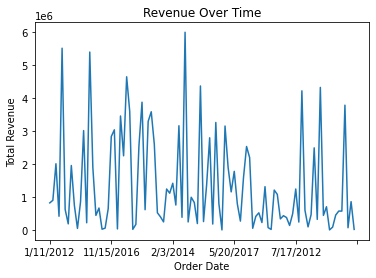

In [61]:
# Plot total revenue over time
df.groupby('Order Date')['Total Revenue'].sum().plot(title='Revenue Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Revenue')

<AxesSubplot:title={'center':'Revenue by Region'}, ylabel='Region'>

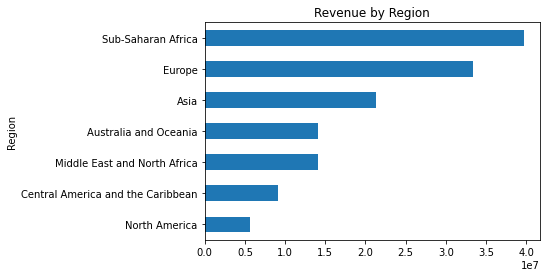

In [62]:
# Plot revenue by region 
df.groupby('Region')['Total Revenue'].sum().sort_values().plot(kind='barh', title='Revenue by Region')

<AxesSubplot:title={'center':'Revenue by Product'}, xlabel='Item Type'>

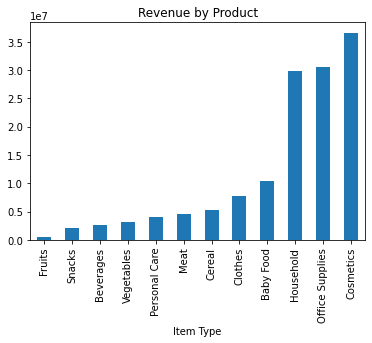

In [63]:
#Plot revenue by product category
df.groupby('Item Type')['Total Revenue'].sum().sort_values().plot(kind='bar', title='Revenue by Product')


In [81]:
np.corrcoef(df.loc[:,'Total Revenue'].iloc[:],df.loc[:,'Total Profit'].iloc[:])

array([[1.        , 0.89732687],
       [0.89732687, 1.        ]])

The high value of Pearson correlation coefficient between Total Revenue and Total Profit indicates that these two variables are closely related to each other.
If revenue generated is high, then more profit will be generated and vice versa.
The negative value of correlation coefficient among Units Sold and Unit Cost implies that quantity of products is inversely proportional to their cost. Same is the scenario with Units Sold and Units Price. Lesser the number of units of a product available, more will be it's price.

In [82]:
np.average(df['Total Profit'])

441681.98399999994

At an average the profit generated by the product is ₹441681.98.

In [84]:
np.max(df['Total Profit'])

1719922.04

In [85]:
np.min(df['Total Profit'])

1258.02

In [86]:
np.var(df['Total Profit'])

190392340968.9648

Maximum and minimum profit generated are ₹ 1719922.04 and ₹ 1258.09 respectively.

Let us understand total Revenue

In [87]:
np.max(df['Total Revenue'])

5997054.98

In [88]:
np.min(df['Total Revenue'])

4870.26

In [89]:
np.mean(df['Total Revenue'])

1373487.6830999998

In [90]:
np.var(df['Total Revenue'])

2110366986501.2166

In [91]:
np.std(df['Total Revenue'])

1452710.2211044075

In [92]:
np.median(df['Total Revenue'])

752314.36

In [93]:
np.percentile(df['Total Revenue'],50,axis=0,overwrite_input=True)

752314.36

In the above results we can see that maximum and minimum revenue generated by the product are ₹ 5997054.98 and ₹ 4870.26.

We can also conclude from above results that revenue has very high variability in it's distribution. The median revenue generated is ₹ 752314.36.

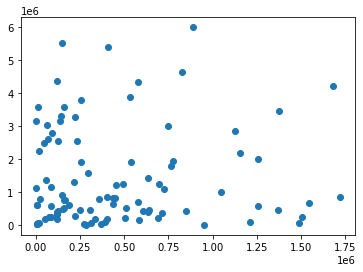

In [96]:
mp.scatter(df['Total Profit'],df['Total Revenue'])

The scatter plot also concludes that total profit and total revenue are directly proportional to each other.

In [97]:
np.correlate(df['Total Revenue'],df['Total Profit'])

array([6.48023895e+13])

(array([33., 20.,  7.,  6.,  3.,  3.,  2.,  3.,  5.,  4.,  3.,  5.,  1.,
         0.,  0.,  2.,  0.,  0.,  1.,  2.]),
 array([3.61224000e+03, 2.28921326e+05, 4.54230412e+05, 6.79539498e+05,
        9.04848584e+05, 1.13015767e+06, 1.35546676e+06, 1.58077584e+06,
        1.80608493e+06, 2.03139401e+06, 2.25670310e+06, 2.48201219e+06,
        2.70732127e+06, 2.93263036e+06, 3.15793944e+06, 3.38324853e+06,
        3.60855762e+06, 3.83386670e+06, 4.05917579e+06, 4.28448487e+06,
        4.50979396e+06]),
 <BarContainer object of 20 artists>)

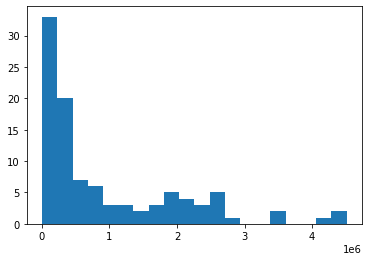

In [99]:
mp.hist(df['Total Cost'],bins=20)

In [100]:
df.corr(method='pearson')

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
Order ID,1.000000,-0.222907,-0.190941,-0.213201,0.001235,-0.328944,-0.234638
Units Sold,-0.222907,1.000000,-0.070486,-0.092232,0.127583,0.374746,0.564550
Unit Price,-0.190941,-0.070486,1.000000,0.987270,0.007902,0.787905,0.557365
Unit Cost,-0.213201,-0.092232,0.987270,1.000000,-0.001689,0.774895,0.467214
Total Revenue,0.001235,0.127583,0.007902,-0.001689,1.000000,-0.009489,0.065280
Total Cost,-0.328944,0.374746,0.787905,0.774895,-0.009489,1.000000,0.804091
Total Profit,-0.234638,0.564550,0.557365,0.467214,0.065280,0.804091,1.000000


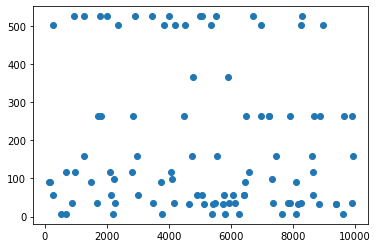

In [101]:
mp.scatter(df['Units Sold'],df['Unit Cost'])

The above scatter plot implies that 'Units Sold' and 'Unit Cost' are inversely proportional to each other. When the number of products sold are more then the cost of products decreases.

Text(0, 0.5, 'Total Profit')

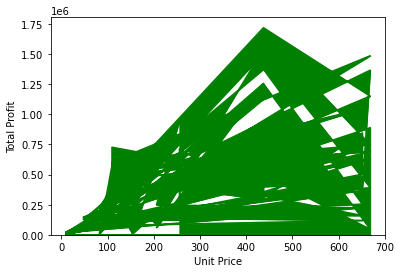

In [105]:
area_plot = df.plot.area(x='Unit Price',y='Total Profit',color='green',stacked=True,legend=None)
mp.ylabel('Total Profit')

 We can see the maximum profit has been generated in the unit price range of ₹400-₹500.

Text(0, 0.5, 'Total Profit')

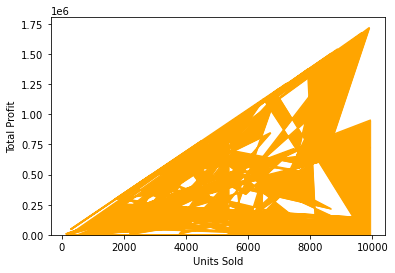

In [103]:
df.plot.area(x='Units Sold',y='Total Profit',color='orange',legend=None)
mp.ylabel('Total Profit')

We can conclude the maximum profit has been generated when the number of units sold were between 8000 and 10000 i.e. more the number of units sold, more will be the profit generated.

Text(0, 0.5, 'Total Cost')

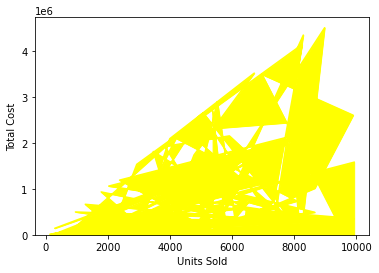

In [108]:
df.plot.area(x='Units Sold',y='Total Cost',color='yellow',legend=None)
mp.ylabel('Total Cost')

Maximum cost has been generated when 8000-9000 units were sold.

Text(0, 0.5, 'Total Revenue')

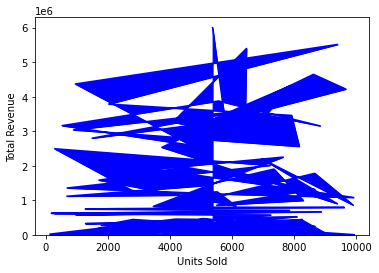

In [109]:
df.plot.area(x='Units Sold',y='Total Revenue',color='blue',legend=None)
mp.ylabel('Total Revenue')

Maximum revenue has been generated when products in the range 5000-6500 units were sold.

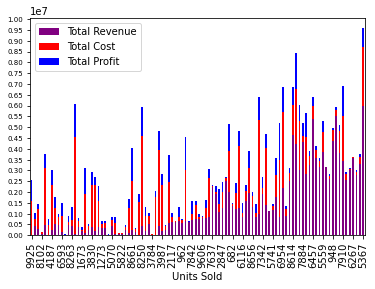

In [110]:
bar_plot = df.plot.bar(x='Units Sold',y=['Total Revenue','Total Cost','Total Profit'],color=['purple','red','blue'],stacked=True,rot=True)
mp.xticks(rotation=90)
mp.locator_params(nbins=38)
mp.tick_params(axis='y', which='major', labelsize=7)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Australia and Oceania'),
  Text(1, 0, 'Central America and the Caribbean'),
  Text(2, 0, 'Europe'),
  Text(3, 0, 'Sub-Saharan Africa'),
  Text(4, 0, 'Asia'),
  Text(5, 0, 'Middle East and North Africa'),
  Text(6, 0, 'North America')])

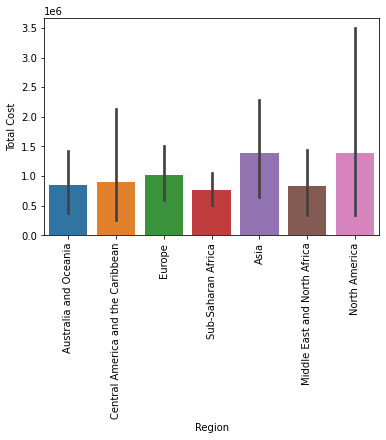

In [113]:
sns.barplot(x='Region',y='Total Cost',data=df)
mp.xticks(rotation=90)

Cost of items is maximum in Asia and North America, and minimum in Sub-Saharan Africa.

In [114]:
np.cov(df['Unit Price'],df['Total Cost'])

array([[5.55037038e+04, 2.01205393e+08],
       [2.01205393e+08, 1.17492213e+12]])

In [115]:
np.corrcoef(df['Unit Price'],df['Total Cost'])

array([[1.        , 0.78790543],
       [0.78790543, 1.        ]])

The high value of degree of correlation between 'Unit Price' and 'Total Cost' variables indicates that they are almost directly proportional to each other and as the unit price of the product increases the total cost increases.


In [116]:
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,5/28/2010,669165933,6/27/2010,9925,255.28,159.42,4870.26,1582243.50,951410.50
1,Central America and the Caribbean,Grenada,Cereal,Online,C,8/22/2012,963881480,9/15/2012,2804,205.70,117.11,445033.55,328376.44,248406.36
2,Europe,Russia,Office Supplies,Offline,L,5/2/2014,341417157,5/8/2014,1779,651.21,524.96,272410.45,933903.84,224598.75
3,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Online,C,6/20/2014,514321792,7/5/2014,8102,9.33,6.92,75591.66,56065.84,19525.82
4,Sub-Saharan Africa,Rwanda,Office Supplies,Offline,L,2/1/2013,115456712,2/6/2013,5062,651.21,524.96,471336.91,2657347.52,639077.50


In [117]:
df['Order Priority'].unique()

array(['H', 'C', 'L', 'M'], dtype=object)

In [119]:
order_priorities = ['H', 'C', 'L', 'M']

In [120]:
df['Order Priority'] = pd.Categorical(df['Order Priority'],categories=order_priorities,ordered=True)

Text(0, 0.5, 'Total Revenue')

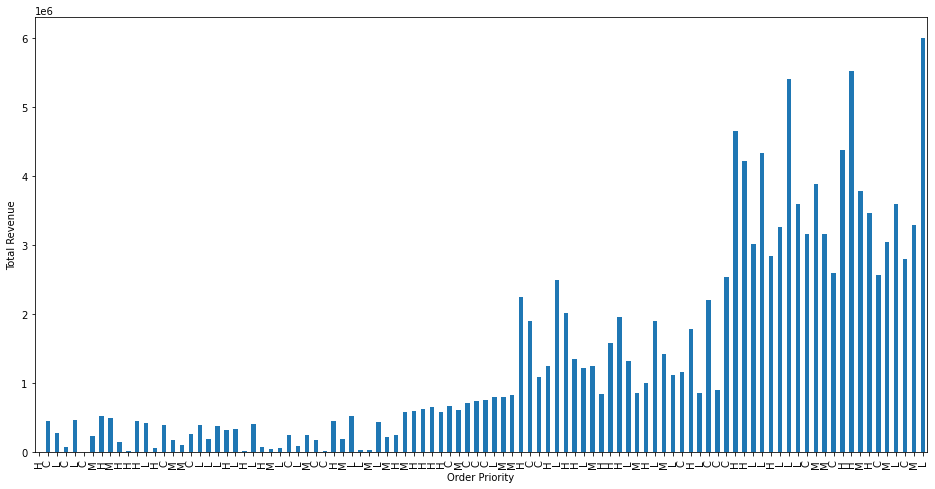

In [122]:
df.plot.bar(x='Order Priority',y='Total Revenue',legend=None,figsize=(16,8))
plt.xticks(rotation='vertical')
mp.ylabel('Total Revenue')

Text(0, 0.5, 'Total Revenue')

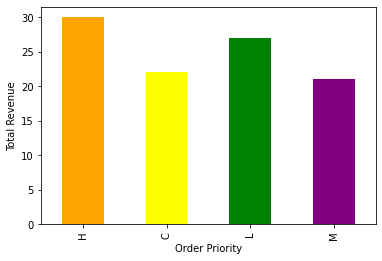

In [124]:
df.groupby('Order Priority')['Total Revenue'].count().plot(kind='bar',color=['orange','yellow','green','purple'])
mp.ylabel('Total Revenue')

Maximum number of revenues has been generated by the products having order priority 'H' while minimum revenues has been generated by 'M' priority products.

Text(0.5, 1.0, 'Distribution of profit on the basis of order priority')

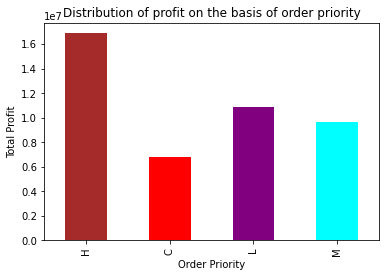

In [125]:
df.groupby('Order Priority')['Total Profit'].sum().plot(kind='bar',color=['brown','red','purple','aqua'])
mp.ylabel('Total Profit')
mp.title('Distribution of profit on the basis of order priority')

Maximum profit has been generated by products having order priority 'H' while minimum profit has been obtained in case of 'C' priority product orders.

Text(0, 0.5, 'Total Profit')

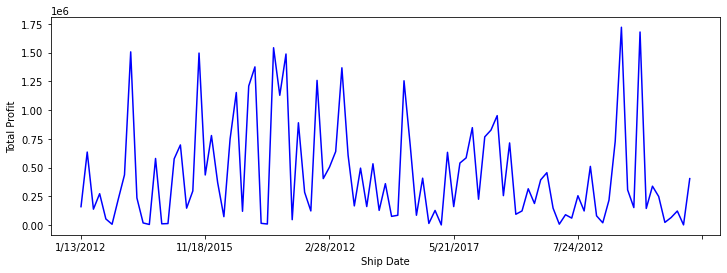

In [133]:
mp.figure(figsize=(12,4))
df.groupby('Ship Date')['Total Profit'].sum().plot(kind='line',color='blue',sort_columns=True)
mp.ylabel('Total Profit')

In [135]:
df['Item Type'].value_counts()

Clothes            13
Cosmetics          13
Office Supplies    12
Fruits             10
Personal Care      10
Household           9
Beverages           8
Baby Food           7
Cereal              7
Vegetables          6
Snacks              3
Meat                2
Name: Item Type, dtype: int64

In [136]:
df['Item Type'].dropna(inplace=True)

In [137]:
labels = df['Item Type'].value_counts().index

In [139]:
sizes = df['Item Type'].value_counts().values
colors = ['yellow','orange','red','lime','purple','aqua']

Text(0.5, 1.0, 'Distribution of Item Types')

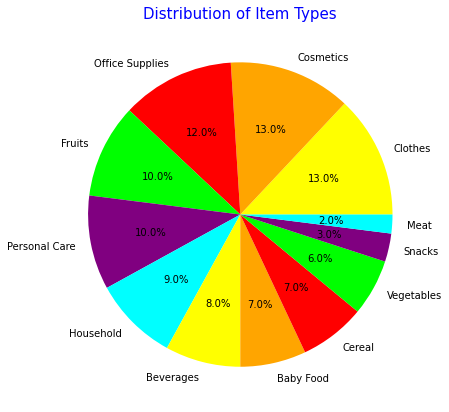

In [140]:
mp.figure(figsize=(7,7))
mp.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%')
mp.title('Distribution of Item Types',fontsize=15,color='blue')

Clothes and cosmetics are the most bought products while meat and snacks are the least bought ones.